In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --upgrade fastai

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0 MB 8.2 kB/s 
     |████████████████████████████████| 5.9 MB 40.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+35d732a
    Uninstalling torchvision-0.6.0a0+35d732a:
      Successfully uninstalled torchvision-0.6.0a0+35d732a
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

kornia 0.3.2 requires torch<1.6.0,>=1.5.0, but you'll have torch 1.6.0+cu101 which is incompatible.
allennlp 1.0.0 requires torch<1.6.0,>=1.5.0, but you'll have torch 1.

In [2]:
import torch
import torch.nn as nn
from fastai.vision.all import * 

In [3]:
!nvidia-smi

Mon Sep 21 14:38:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
torch.__version__

'1.6.0+cu101'

In [5]:
torch.cuda.is_available()

True

In [6]:
path = Path('/kaggle/input/siim-isic-melanoma-classification/')
path.ls()

(#7) [Path('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv'),Path('/kaggle/input/siim-isic-melanoma-classification/tfrecords'),Path('/kaggle/input/siim-isic-melanoma-classification/test'),Path('/kaggle/input/siim-isic-melanoma-classification/jpeg'),Path('/kaggle/input/siim-isic-melanoma-classification/train'),Path('/kaggle/input/siim-isic-melanoma-classification/test.csv'),Path('/kaggle/input/siim-isic-melanoma-classification/train.csv')]

In [7]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
print("train_df: ", train_df.shape)
print("test_df: ", test_df.shape)

train_df:  (33126, 8)
test_df:  (10982, 5)


In [8]:
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [9]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (t_, v_) in enumerate(skf.split(X=train_df.values, y=train_df.target.values)):
    train_df.loc[v_, 'fold'] = fold

In [10]:
for fold in range(5):
    print("fold:", fold, end=" - ")
    print(len(train_df[train_df['fold'] == fold]))

fold: 0 - 6626
fold: 1 - 6625
fold: 2 - 6625
fold: 3 - 6625
fold: 4 - 6625


In [11]:
def get_x(df):
    image_name = df['image_name']
    return path/'jpeg'/'train'/f'{image_name}.jpg'
def get_y(df):
    return df['target']
def splitter(df, fold=0):
    train = df.index[df.fold != fold].tolist()
    valid = df.index[df.fold == fold].tolist()
    return train, valid

In [12]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=RandomResizedCrop(128, min_scale=0.35),
)
dls = dblock.dataloaders(train_df)

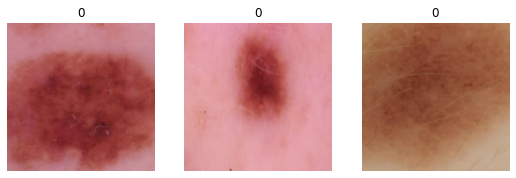

In [13]:
dls.show_batch(nrows=1, ncols=3)

In [14]:
dls.device

device(type='cuda', index=0)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [16]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.164442,0.122345,0.979623,1:49:31


epoch,train_loss,valid_loss,accuracy,time
0,0.077644,0.084212,0.980679,1:50:04
